In [ ]:
!pip install yfinance
!pip install keras-tuner

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import SimpleRNN, Dense, Dropout
from kerastuner.tuners import BayesianOptimization
from keras.models import Sequential
from keras.optimizers import Adam

In [38]:
goog = yf.download("GOOG", start = "2012-01-01",
                   end = "2021-01-01")

df = goog[["Adj Close", "Open", "Close", "High", "Low"]].round(3)
df

[*********************100%***********************]  1 of 1 completed


,Adj Close,Open,Close,High,Low
Date,,,,,
2012-01-03,16.573,16.263,16.573,16.641,16.248
2012-01-04,16.645,16.564,16.645,16.694,16.454
2012-01-05,16.414,16.491,16.414,16.537,16.344
2012-01-06,16.190,16.417,16.190,16.438,16.184
2012-01-09,15.503,16.102,15.503,16.115,15.473
...,...,...,...,...,...
2020-12-24,86.942,86.750,86.942,87.300,86.455
2020-12-28,88.804,87.582,88.804,89.536,87.317
2020-12-29,87.936,89.390,87.936,89.622,87.804


In [39]:
train_df = df[:"2018"].Close.values.reshape(-1 ,1)
test_df = df["2018":].Close.values.reshape(-1 ,1)

print(f"Total Data{len(df)}")
print(f"Train Data{len(train_df)}")
print(f"Test Data{len(test_df)}")

Total Data2265
Train Data1760
Test Data756


In [40]:
def ts_data(df, X_steps, y_steps):
  train_df = df[:"2018"].Close.values.reshape(-1 ,1)
  test_df = df["2018":].Close.values.reshape(-1 ,1)

  sc = MinMaxScaler(feature_range=(0, 1))
  train_df_scale = sc.fit_transform(train_df)

  X_train = []
  y_train = []

  for i in range(X_steps, len(train_df_scale)-y_steps+1):
    X_train.append(train_df_scale[i-X_steps:i, 0])
    y_train.append(train_df_scale[i:i+y_steps, 0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1 ,1)
  X = sc.transform(X)

  X_test = []
  y_test = []

  for i in range(X_steps, len(test_df)+X_steps-y_steps+1):
    X_test.append(X[i-X_steps:i, 0])
    y_test.append(X[i:i+y_steps, 0])
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  X_test = X_test.reshape([X_test.shape[0], X_test.shape[1], 1])

  return X_train, y_train, X_test, y_test, sc

In [41]:
X_train, y_train, X_test, y_test , sc = ts_data(df, 6, 2)

In [42]:
X_train.shape

(1753, 6, 1)

In [43]:
X_test.shape

(755, 6, 1)

In [57]:
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                     input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=y_train.shape[1]))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_absolute_error')
    return model

In [58]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') < 0.05:
            print('\nValidation loss decreased below 0.05, stopping training...')
            self.model.stop_training = True

In [59]:
def model_fit(X_train, y_train, X_test, y_test, tuner):
    custom_callback = CustomCallback()
    tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[custom_callback])
    best_model = tuner.get_best_models(num_models=1)[0]
    best_params = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f'Best Parameters: {best_params}')
    print(f'Best Model: {best_model}')
    return best_model

In [60]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuner_bayesian_opt'
)

best_model = model_fit(X_train, y_train, X_test, y_test, tuner)

Trial 10 Complete [00h 00m 20s]
val_loss: 0.04575696587562561

Best val_loss So Far: 0.03608260303735733
Total elapsed time: 00h 02m 45s
Best Parameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f79082affd0>
Best Model: <keras.engine.sequential.Sequential object at 0x7f7904d42440>


In [61]:
best_model = best_model.predict(X_test)
best_model.shape

24/24 [==============================] - 1s 18ms/step


(755, 2)

In [67]:
def prediction_plot(predictions):
  fig, ax = plt.subplots()
  ax.plot(df["2018":].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1 , 1)), label = "Real")
  ax.plot(df["2018":].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1 , 1)), label = "Predictions")

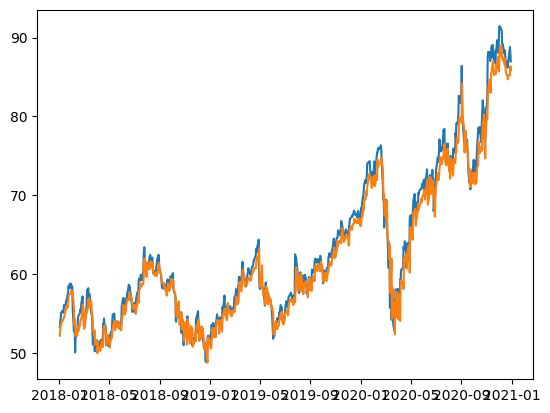

In [68]:
prediction_plot(best_model)